## Cost Profiling UDPs

In this notebook we detail how one can profile the credit cost of their UDP. Providing such information can by highly informative when sharing the UDP with other users, or when trying to optimize you own personal UDP. 

In this example we will profile the max ndvi udp as a function of the spatial and temporal input size.
We will do this by creating variable spatial and temporal extends form a fixed staring point.

In [1]:
import sys

# Add the path where esa_apex_toolbox is located
sys.path.append(r'C:\Git_projects\esa-apex-toolbox-python\src')

from esa_apex_toolbox.algorithms import GithubAlgorithmRepository
import openeo
from openeo.extra.job_management import MultiBackendJobManager
import pandas as pd

This example fetches an existing APEx algorithm from the catalog, but it is also relatively easy to work with any other openEO process.

In [2]:
catalog = GithubAlgorithmRepository(
            owner="ESA-APEx",
            repo="apex_algorithms",
            folder="algorithm_catalog",
        )
catalog.list_algorithms()

['max_ndvi_composite.json', 'worldcereal_inference.json']

We select the algorithm of our choosing

In [5]:
algorithm = catalog.get_algorithm("max_ndvi_composite.json")
algorithm

Algorithm(id='max_ndvi_composite', title='Max NDVI Composite based on Sentinel-2 data', description='A compositing algorithm for Sentinel-2 L2A data, ranking observations by their maximum NDVI.', udp_link=UdpLink(href='https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/max_ndvi_composite/openeo_udp/examples/max_ndvi_composite/max_ndvi_composite.json', title='openEO Process Definition'), service_links=[ServiceLink(href='https://openeofed.dataspace.copernicus.eu', title='CDSE openEO federation')], license=None, organization='VITO')

## Prepare jobs database

In order to profile the UDP we will make use of openEO's MultiBackendJobManager. This Job manager requires oen to set up a dataframe which contains all input parameters for the jobs we wish to run.

Hence we will create a dataframe containing all combinations of the input variables over which we want to profile the UDP. In order to make sure we are not influenced to much by the current load of the backend of choice, we will include multiple repetitions of every combination and average the output out later on

First, we set constant values which will define around which spatio-temporal location we will calculate the UDP's profile.
In addition we define the ranges over which we want to calculate the profile. 

In [6]:
BASE_SPATIAL_START = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
BASE_TEMPORAL_START = '2020-01-01'

spatial_extents = [10000, 20000] #km extend
temporal_extents = [3, 6] #months
repetition = 1

In [7]:

import pandas as pd
from utils import create_spatial_extent, create_bbox, create_temporal_extent

def prepare_jobs_df() -> pd.DataFrame:
    """Prepare a DataFrame containing job configurations for benchmarking."""
    jobs = []

    # Create combinations for the spatial grid
    for spatial in spatial_extents:
            for temporal in temporal_extents:
                 
                spatial_extent = create_bbox(create_spatial_extent(BASE_SPATIAL_START, spatial))
                temporal_extent = create_temporal_extent(BASE_TEMPORAL_START, temporal)

                for ii in range(repetition):

                        jobs.append({
                            "spatial_extent": spatial_extent,
                            "temporal_extent": temporal_extent,
                        })

    return pd.DataFrame(jobs)

jobs_df = prepare_jobs_df()
print(jobs_df)

                                      spatial_extent           temporal_extent
0  {'west': 5.318868004541495, 'south': 50.625959...  [2020-01-01, 2020-04-01]
1  {'west': 5.318868004541495, 'south': 50.625959...  [2020-01-01, 2020-07-01]
2  {'west': 5.318868004541495, 'south': 50.622890...  [2020-01-01, 2020-04-01]
3  {'west': 5.318868004541495, 'south': 50.622890...  [2020-01-01, 2020-07-01]


## Creating the Job

Define the `start_job` function, which creates the actual job for each row in our jobs DataFrame.
Do note that the `MultiBackendJobManager` expects a start_joc functionality with the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In [9]:
import ast

# Define the start_job function
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row and connection."""
    spatial_extent = row["spatial_extent"]
    temporal_extent = row["temporal_extent"]
    if isinstance(temporal_extent, str):
        temporal_extent = ast.literal_eval( temporal_extent )
    if isinstance(spatial_extent, str):
        spatial_extent = ast.literal_eval( spatial_extent )

    cube = connection.datacube_from_process(
        algorithm.id,
        namespace=algorithm.udp_link.href,
        spatial_extent = spatial_extent, temporal_extent = temporal_extent
    )
    
    return cube.create_job(
        title='Process Graph - Benchmark',
        format="GTiff"
    )


## Running Jobs Using MultiBackendJobManager

With our spatial extents set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining an output file where the job tracker will store the job statuses and metadata.

### Steps to Run the Jobs:

1. Define the Output File:
   The output file will store the job tracker data, including job statuses and metadata.
   Note that this output file needs a unique name and cannot be overwritten or appended to. 

2. Initialize the MultiBackendJobManager:
   We create an instance of the `MultiBackendJobManager` and add a backend of our choice. This backend will be responsible for executing the jobs.

3. Run Multiple Jobs:
   Use `manager.run_jobs` to create the desired jobs and send them to the backend.
   The output file, defined in step 1, will act as a the live job tracker and contain all the information from the original jobs DataFrame, as well as updates on the actual job statuses.

In [19]:
# Run the jobs
# Generate a unique name for the tracker
job_tracker = algorithm.id + '_profiler.csv'

# Initiate MultiBackendJobManager 
manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()

#standard users can run 2 jobs in parallel max
manager.add_backend("cdse", connection=connection, parallel_jobs=10)

# Run the jobs
manager.run_jobs(df=jobs_df, start_job=start_job, job_db=job_tracker)

Authenticated using refresh token.


c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\openeopythonclient\Lib\site-packages\openeo\extra\job_management.py:394: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'cdse' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, "backend_name"] = backend_name
Preflight process graph validation raised: [ProcessParameterInvalid] The value passed for parameter 'temporal_extent' in process 'load_collection' is invalid: should have length 2, but got "['2020-01-01', '2020-04-01']"
c:\Users\VROMPAYH\AppData\Local\anaconda3\envs\openeopythonclient\Lib\site-packages\openeo\extra\job_management.py:410: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-09-20T16:35:53.164845' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, "start_time"] =

In [24]:
import pandas as pd
df = pd.read_csv(output_file)
data_processor = DataProcessor()
df = data_processor.update_job_costs(df, connection)
df = data_processor.add_units_to_column_headers(df)
df = data_processor.clean_units(df)

#
df

,spatial_extent,temporal_extent,process_graph_path,process_graph_id,status,id,start_time,backend_name,job_cost (credits),cpu (cpu-seconds),memory (mb-seconds),duration (seconds),input_pixel (mega-pixel),max_executor_memory (gb),network_received (b)
0,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-03-31']",NDWI.json,NDWI,finished,cdse-j-240919ed913a4db7971fcf4a79d90683,2024-09-19T12:06:01.611506,cdse,5.0,856.0,5018324.0,202.0,117.046875,1.748386,1.001021e+10
1,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-06-29']",NDWI.json,NDWI,finished,cdse-j-240919a6fbdf49e6b9a6a9683034159c,2024-09-19T12:06:19.221912,cdse,6.0,1747.0,9195072.0,295.0,260.000000,1.793736,4.856788e+10
2,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-12-26']",NDWI.json,NDWI,finished,cdse-j-240919ecf0cc4300a53d28065c44b18f,2024-09-19T12:10:48.098538,cdse,8.0,2657.0,12053896.0,328.0,420.968750,1.960876,9.832976e+10
3,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-03-31']",NDWI.json,NDWI,finished,cdse-j-240919b195594c75bb48029918597ba2,2024-09-19T12:13:06.228682,cdse,6.0,1944.0,9597236.0,266.0,454.390625,1.888367,2.855507e+10
4,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-06-29']",NDWI.json,NDWI,finished,cdse-j-2409193be95f4953986c406a38bc4a88,2024-09-19T12:17:45.518759,cdse,8.0,3526.0,13839433.0,368.0,1028.796875,2.059891,8.761643e+10
5,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-12-26']",NDWI.json,NDWI,finished,cdse-j-240919c72d5c49d09a79dbdc2ef3261e,2024-09-19T12:19:07.779889,cdse,11.0,5694.0,21203474.0,510.0,1662.156250,2.224918,1.639712e+11
6,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-03-31']",NDWI.json,NDWI,finished,cdse-j-240919b092444d2697f0ce68c0c8cfce,2024-09-19T12:51:22.297596,cdse,12.0,5585.0,23477699.0,594.0,1952.750000,2.758804,1.042040e+11
7,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-06-29']",NDWI.json,NDWI,finished,cdse-j-24091936899b4ca4b9a1b358ccedc279,2024-09-19T12:51:40.016272,cdse,23.0,12021.0,53128708.0,1043.0,4471.468750,2.896679,2.541585e+11
8,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-12-26']",NDWI.json,NDWI,finished,cdse-j-240919db15114ba88dd0907eed6e9b03,2024-09-19T13:03:01.000710,cdse,33.0,19424.0,78447299.0,1319.0,7136.953125,3.354504,4.246394e+11
9,"{'west': 664000.0, 'south': 5611120.0, 'east':...","['2020-01-01', '2020-03-31']",NDWI.json,NDWI,finished,cdse-j-240919754f2a48fa94e93136c197f7b2,2024-09-19T13:11:00.004254,cdse,6.0,740.0,7375953.0,458.0,117.046875,1.724537,2.452855e+10


In [25]:
df.to_csv('final_' + output_file, index=False)

# Metrics plots

Results are plotted to allow visual inspection.

The heatmap shows cost as a function of 2 parameters. This is useful to see which parameter has more impact on cost.

The second plot shows cost versus the amount of input data (pixels). This gives a good idea of how the process scales.
A scatter plot is used, so you get a sense of the cost variation, which can be relatively significant especially for smaller jobs.

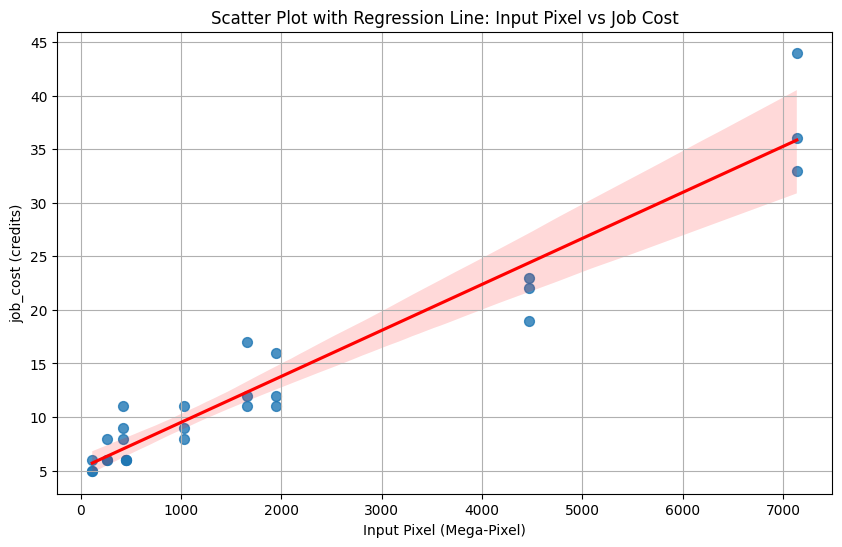

In [27]:
# Plotting

plotter = Plotter()
#the heatmap seems to lack temporal and spatial range columns?
#plotter.plot_heatmap(df, 'job_cost (credits)')
plotter.plot_scatter_with_fit(df, 'job_cost (credits)')